# 🌐 Wikipedia recommender system
- Zuzanna Gawrysiak 148255
- Agata Żywot 148258

### Description (straight from ekursy - to be deleted later)


The general task is to create a system that will recommend similar articles based on the previously visited articles.

**Input - Collection of articles (links or titles), Output - Collection of recommended articles (links or titles) with a "score"**


You will receive a grade for each of the following steps. The highest possible score without
finishing all parts is 4.0. For example, if you do perfectly the first two steps your grades will be 4.0,
4.0, 2.0.


**Crawling and scraping** - Download text from at least 1000 Wikipedia/fandom wiki articles.
(Scrappy is not a must)


**Stemming, lemmatization** - preprocess downloaded documents into the most suitable form for this
task. Store it as a .csv/parquet file or into a database.


**Similarities** - for a given collection of previously visited articles find the best matches in your
database and recommend them to the user


GUI not required, notebook or any other reasonable form will be accepted. I have to be able to
provide a list of articles in an easy way and receive a meaningful recommendation.
You have to send the source code and report.


Report:
- pdf or notebook
- explain each step of your algorithm, especially how you score articles
- present interesting statistics about your database (most frequent words, histograms, similarities
between documents, ...)
- show some examples of recommendations with explanations (I'd prefer graphical form - see
prediction breakdowns for example)

## Import necessary libraries

In [ ]:
%pip install pyldavis
%pip install wikipedia

In [1]:
import random
import linecache
import wikipedia
import re
import requests
import bs4
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from wordcloud import WordCloud

import pyLDAvis
import pyLDAvis.sklearn

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, wordpunct_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\agata\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\agata\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\agata\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Scraping wikipedia articles

In [ ]:
N = 1100
with open(r'./data/titles.txt', 'r') as fp:
    num_lines = sum(1 for line in fp)
    # print('Total lines:', num_lines) 

In [ ]:
# get N article titles
random.seed(2137)
line_numbers = random.sample(range(1, num_lines), N)

titles = []
for i in line_numbers:
    x = linecache.getline(r'./data/titles.txt', i).strip()
    titles.append(x)
print(titles[:5])

## Stemming, lemmatization

In [12]:
def preprocess(article):
    """
    Tokenize given article, remove stopwords, numbers, then perform stemming
    """
    preprocessed = []
    porter = PorterStemmer()
    tokenized = word_tokenize(article)
    sw = stopwords.words('english')

    for word in tokenized:
        if word.isalpha() and word not in sw:
            preprocessed.append(porter.stem(word)) # stemming is faster than lematization, but has lower accuracy (can try both later)
    return ' '.join(preprocessed)

In [ ]:
def save_pages_content(titles):
    """
    Create a csv file with all pages information necessary
    """
    df = pd.DataFrame({'title':[],
                        'url':[],
                        'body':[]})
    
    for title in titles:
        try: 
            page = wikipedia.page(title)
        except:
            print(f'No page of title {title}!')
            continue 
        d = dict()
        d['title'] = page.title
        d['url'] = page.url
        body = re.sub(r'==.*?==+', '', page.content)
        d['body'] = preprocess(body)
        df.loc[len(df.index)] = [d['title'], d['url'], d['body']]

    df.to_csv('./data/articles.csv', encoding='utf-8', index=False)

In [ ]:
# save_pages_content(titles)

In [2]:
df = pd.read_csv('./data/articles.csv')
df.tail()

,title,url,body
1154,Rathnew GAA,https://en.wikipedia.org/wiki/Rathnew_GAA,rathnew gaa gaelic footbal club rathnew counti...
1155,Muhammad ibn Abd al-Wahhab,https://en.wikipedia.org/wiki/Muhammad_ibn_Abd...,muhammad ibn abd ibn sulayman arab محمد بن عبد...
1156,Sorel-Tracy Éperviers,https://en.wikipedia.org/wiki/Sorel-Tracy_%C3%...,the épervier hawk hockey team base quebec the ...
1157,Jacob Tonson,https://en.wikipedia.org/wiki/Jacob_Tonson,jacob tonson sometim refer jacob tonson elder ...
1158,William Arnald,https://en.wikipedia.org/wiki/William_Arnald,william arnald bd die august canon windsor he ...


## Count vector
Store articles as numbers of occurences of words.

In [3]:
CountVec = CountVectorizer(ngram_range=(1,1), stop_words='english')
CountData = CountVec.fit_transform(df.body)
 
CountData
# if dataset is too large, try: https://scikit-learn.org/stable/modules/feature_extraction.html#vectorizing-a-large-text-corpus-with-the-hashing-trick 

<1159x52056 sparse matrix of type '<class 'numpy.int64'>'
	with 377516 stored elements in Compressed Sparse Row format>

In [4]:
pd.set_option('display.max_columns', 1000)
dfCV = pd.DataFrame(CountData.toarray(), columns=CountVec.get_feature_names_out(), index=df.url)
# dfCV

## Database analysis
> present interesting statistics about your database (most frequent words, histograms, similarities between documents, ...)

### Most frequent words

Top five most frequent words:
use       4615
state     3923
new       3063
includ    2721
unit      2652
dtype: int64


<AxesSubplot:title={'center':'Most frequent words'}>

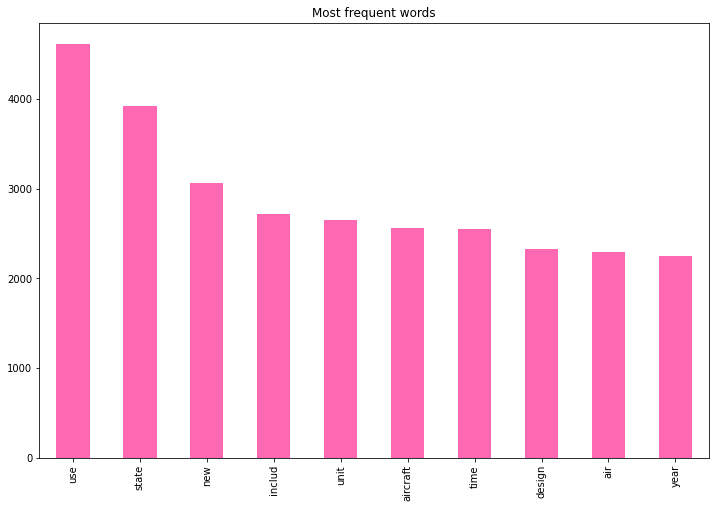

In [5]:
word_sums = dfCV.sum(axis=0)
word_sums = word_sums.sort_values(ascending=False)
print(f"Top five most frequent words:\n{word_sums[:5]}")
word_sums[:10].plot(kind='bar', figsize=(12,8), title="Most frequent words", color='hotpink')

All words as a wordcloud

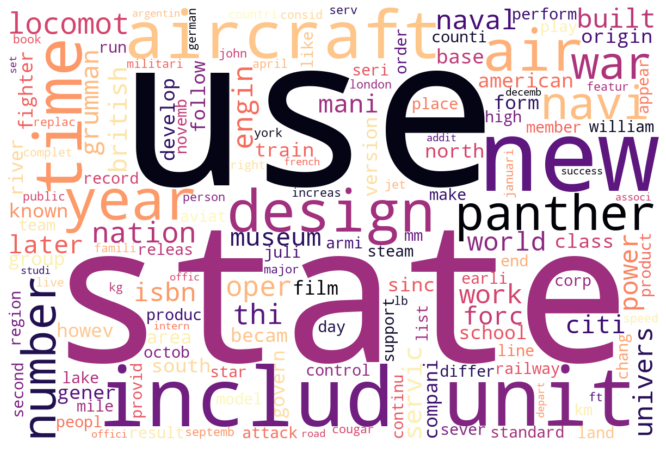

In [6]:
def generate_wordcloud(data):
    wc = WordCloud(width=1200, height=800, max_words=150, background_color='white', colormap='magma').generate_from_frequencies(data)
    plt.figure(figsize=(12,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

generate_wordcloud(word_sums)

### Similarities between documents

Check the similarities using LDA (Latent Drichlet Allocation). 

In [7]:
lda_tf = LatentDirichletAllocation(n_components=3, random_state=0) # number of articles
lda_tf.fit(CountData)

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_tf, CountData, CountVec, mds='tsne')
panel

c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\ag

PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
2     -1015.700562  1338.981201       1        1  42.696081
1      -387.996002  -373.316162       2        1  36.610932
0     -2184.745605   -60.565800       3        1  20.692987, topic_info=           Term         Freq        Total Category  logprob  loglift
818    aircraft  2276.000000  2276.000000  Default  30.0000  30.0000
33297   panther  1994.000000  1994.000000  Default  29.0000  29.0000
30669      navi  1747.000000  1747.000000  Default  28.0000  28.0000
808         air  2053.000000  2053.000000  Default  27.0000  27.0000
30656     naval  1528.000000  1528.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
11365    design   863.596723  2161.684658   Topic3  -5.3372   0.6578
42816     state  1029.040493  3680.534755   Topic3  -5.1619   0.3009
48945       war   715.873234  1825.892960   Topic3  -5.5248   0.6391
35407     power   599.187094  1449.677712   Topic3  -5.7027   0.6919
3797       base   571.080951  1252.742075   Topic3  -5.7508   0.7898

[257 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
561        3  0.995974  aeronav
596        3  0.997577      afb
808        1  0.090586      air
808        2  0.016559      air
808        3  0.892712      air
...      ...       ...      ...
50355      1  0.506294     year
50355      2  0.406153     year
50355      3  0.087565     year
50850      1  0.979970     zinc
50850      2  0.019055     zinc

[431 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

### Conclusions from analysis
* the most frequent word is ...
* bla bla

## TFIDF approach
Count vector was for showing some interesteing statistics, but for the recommendation we will use TFIDF.

In [8]:
tfidf = TfidfVectorizer(ngram_range=(1,1), use_idf=True, smooth_idf=False, stop_words='english') 
tfidf_data = tfidf.fit_transform(df.body) 
dfTFIDF = pd.DataFrame(tfidf_data.toarray(), index=df.url, columns=tfidf.get_feature_names_out())
dfTFIDF

aa  aaa  aabar  aabcd  \
url                                                                          
https://en.wikipedia.org/wiki/Thomas_Daniel_Winter  0.0  0.0    0.0    0.0   
https://en.wikipedia.org/wiki/William_Back          0.0  0.0    0.0    0.0   
https://en.wikipedia.org/wiki/Rofa-Stadion          0.0  0.0    0.0    0.0   
https://en.wikipedia.org/wiki/1989_Clemson_Tige...  0.0  0.0    0.0    0.0   
https://en.wikipedia.org/wiki/George_Kalinsky       0.0  0.0    0.0    0.0   
...                                                 ...  ...    ...    ...   
https://en.wikipedia.org/wiki/Rathnew_GAA           0.0  0.0    0.0    0.0   
https://en.wikipedia.org/wiki/Muhammad_ibn_Abd_...  0.0  0.0    0.0    0.0   
https://en.wikipedia.org/wiki/Sorel-Tracy_%C3%8...  0.0  0.0    0.0    0.0   
https://en.wikipedia.org/wiki/Jacob_Tonson          0.0  0.0    0.0    0.0   
https://en.wikipedia.org/wiki/William_Arnald        0.0  0.0    0.0    0.0   

                                                    aac  aachen  aacsb  \
url                                                                      
https://en.wikipedia.org/wiki/Thomas_Daniel_Winter  0.0     0.0    0.0   
https://en.wikipedia.org/wiki/William_Back          0.0     0.0    0.0   
https://en.wikipedia.org/wiki/Rofa-Stadion          0.0     0.0    0.0   
https://en.wikipedia.org/wiki/1989_Clemson_Tige...  0.0     0.0    0.0   
https://en.wikipedia.org/wiki/George_Kalinsky       0.0     0.0    0.0   
...                                                 ...     ...    ...   
https://en.wikipedia.org/wiki/Rathnew_GAA           0.0     0.0    0.0   
https://en.wikipedia.org/wiki/Muhammad_ibn_Abd_...  0.0     0.0    0.0   
https://en.wikipedia.org/wiki/Sorel-Tracy_%C3%8...  0.0     0.0    0.0   
https://en.wikipedia.org/wiki/Jacob_Tonson          0.0     0.0    0.0   
https://en.wikipedia.org/wiki/William_Arnald        0.0     0.0    0.0   

                                                    aadukalam  aadukirathu  \
url                                                                          
https://en.wikipedia.org/wiki/Thomas_Daniel_Winter        0.0          0.0   
https://en.wikipedia.org/wiki/William_Back                0.0          0.0   
https://en.wikipedia.org/wiki/Rofa-Stadion                0.0          0.0   
https://en.wikipedia.org/wiki/1989_Clemson_Tige...        0.0          0.0   
https://en.wikipedia.org/wiki/George_Kalinsky             0.0          0.0   
...                                                       ...          ...   
https://en.wikipedia.org/wiki/Rathnew_GAA                 0.0          0.0   
https://en.wikipedia.org/wiki/Muhammad_ibn_Abd_...        0.0          0.0   
https://en.wikipedia.org/wiki/Sorel-Tracy_%C3%8...        0.0          0.0   
https://en.wikipedia.org/wiki/Jacob_Tonson                0.0          0.0   
https://en.wikipedia.org/wiki/William_Arnald              0.0          0.0   

                                                    aah  aai  aakhaan  \
url                                                                     
https://en.wikipedia.org/wiki/Thomas_Daniel_Winter  0.0  0.0      0.0   
https://en.wikipedia.org/wiki/William_Back          0.0  0.0      0.0   
https://en.wikipedia.org/wiki/Rofa-Stadion          0.0  0.0      0.0   
https://en.wikipedia.org/wiki/1989_Clemson_Tige...  0.0  0.0      0.0   
https://en.wikipedia.org/wiki/George_Kalinsky       0.0  0.0      0.0   
...                                                 ...  ...      ...   
https://en.wikipedia.org/wiki/Rathnew_GAA           0.0  0.0      0.0   
https://en.wikipedia.org/wiki/Muhammad_ibn_Abd_...  0.0  0.0      0.0   
https://en.wikipedia.org/wiki/Sorel-Tracy_%C3%8...  0.0  0.0      0.0   
https://en.wikipedia.org/wiki/Jacob_Tonson          0.0  0.0      0.0   
https://en.wikipedia.org/wiki/William_Arnald        0.0  0.0      0.0   

                                                         aal  aalavandhan  \
url                              

Save the obtained data frame to csv file.

## Recommender system - similarities

In [9]:
def getText(url):
    response = requests.get(url)
    assert(response.status_code == 200)
    parsed = bs4.BeautifulSoup(response.text)
    output = ""
    for p in parsed.select('p'):
      output += p.getText()
    return output

In [10]:
def get_recommendations(df, user_data, mode='query', n=10):
    tfidf = TfidfVectorizer(ngram_range=(1,1), use_idf=True, smooth_idf=False, stop_words='english') 
    tfidf.fit_transform(df.body)
    query = None

    if mode == 'query':
        if isinstance(user_data, list):
            user_data = ' '.join(user_data)
        query = preprocess(user_data)
    
    elif mode == 'url':
        if isinstance(user_data, list):
            query = ''
            for url in user_data:
                query = query + ' ' + preprocess(getText(url))
            
        else:
            query = preprocess(getText(url))

    if query is None:
        return None   
         
    query = tfidf.transform([query]).toarray()[0] 
    return 1-dfTFIDF.apply(lambda x: cosine(x, query), axis=1).sort_values()[:n]

In [13]:
QUERY = 'alternative medicine'
results_query = get_recommendations(df, QUERY)
print(f'Results recommended for the following query: {QUERY}')
print(results_query)

Results recommended for the following query: alternative medicine
url
https://en.wikipedia.org/wiki/Regenerative_medicine                          0.225541
https://en.wikipedia.org/wiki/James_Hamblin_(journalist)                     0.172645
https://en.wikipedia.org/wiki/Peter_Kopelman                                 0.069333
https://en.wikipedia.org/wiki/List_of_emergency_medicine_courses             0.066597
https://en.wikipedia.org/wiki/National_University_of_Colombia                0.065183
https://en.wikipedia.org/wiki/Sterol_regulatory_element-binding_protein_1    0.049201
https://en.wikipedia.org/wiki/Stellastarr                                    0.043820
https://en.wikipedia.org/wiki/PITX2                                          0.034754
https://en.wikipedia.org/wiki/Bromide,_Oklahoma                              0.031856
https://en.wikipedia.org/wiki/RPS6KA1                                        0.031143
dtype: float64


In [14]:
URL = [ 'https://en.wikipedia.org/wiki/Google',
        'https://en.wikipedia.org/wiki/Mobile_phone']
results_url = get_recommendations(df, URL, mode='url')
print(f'Results recommended for the following urls: {URL}')
print(results_url)

Results recommended for the following urls: ['https://en.wikipedia.org/wiki/Google', 'https://en.wikipedia.org/wiki/Mobile_phone']
url
https://en.wikipedia.org/wiki/GSM_services                   0.376283
https://en.wikipedia.org/wiki/Visual_search_engine           0.181718
https://en.wikipedia.org/wiki/Industrial_espionage           0.173150
https://en.wikipedia.org/wiki/Multi-factor_authentication    0.167883
https://en.wikipedia.org/wiki/Samsung_Galaxy_Note_9          0.115593
https://en.wikipedia.org/wiki/Advanced_Video_Coding          0.104422
https://en.wikipedia.org/wiki/Lenovo                         0.101690
https://en.wikipedia.org/wiki/Adam_Aircraft_Industries       0.099587
https://en.wikipedia.org/wiki/LexisNexis                     0.093084
https://en.wikipedia.org/wiki/Minds                          0.092485
dtype: float64
